# About

SHiP track pattern recognition is in this notebook.

# Data

In [1]:
from IPython.parallel import Client

clients = Client()
print clients.ids

[0, 1, 2]


In [2]:
%%px
import os, sys
sys.path.append('../functions')
sys.path.append('Github/ship_tracks_recognition/functions')

import numpy
import pandas

In [3]:
%matplotlib inline
import os, sys
sys.path.append('../functions')
import pandas
import numpy
import matplotlib.pyplot as plt
import cPickle as pickle

In [4]:
all_mctracks = pandas.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pandas.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pandas.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

# Get reconstructible events

In [5]:
from utils import get_reconstractible_events
#reconstructible_events = get_reconstractible_events(range(0, 2500), all_hits, all_mctracks, all_velo_points)

# file_pickle = open('./Data/reco_tracks_for_pattern_recognition.pkl', 'wb')
# pickle.dump(reconstructible_events, file_pickle)
# file_pickle.close()

file_pickle = open('./Data/reco_tracks_for_pattern_recognition.pkl', 'rb')
reconstructible_events_pkl = pickle.load(file_pickle)
file_pickle.close()

reconstructible_events = reconstructible_events_pkl

In [6]:
# reconstructible_events_valid = get_reconstractible_events(range(2500, 5000), all_hits, all_mctracks, all_velo_points)

# file_pickle = open('./Data/reco_tracks_for_pattern_recognition_valid.pkl', 'wb')
# pickle.dump(reconstructible_events_valid, file_pickle)
# file_pickle.close()

file_pickle = open('./Data/reco_tracks_for_pattern_recognition_valid.pkl', 'rb')
reconstructible_events_valid_pkl = pickle.load(file_pickle)
file_pickle.close()

reconstructible_events_valid = reconstructible_events_valid_pkl

In [7]:
numpy.array(reconstructible_events.keys())

array([ 513,    2,  515,  516, 1541,  518,    7,   10, 2059, 1036, 1550,
         15, 2392, 1042, 1557,   23,   27, 2077, 2132, 1057,  549,   39,
       1066, 2482,  558, 2095,   48,  928,   50, 2099,   53, 1204, 1546,
         62, 1600, 2113, 1090, 1206, 1606, 1607, 1548,   74, 1293, 2232,
         84,   85,   86, 1111, 2138, 1116, 1629,  606, 1893,  608,   97,
       1979,  612, 1637,  614, 1129,  106, 1895, 2305, 2157,  622, 1213,
       1136,  625, 1138, 2164, 1142, 1655,  122, 1385,  126,  686,  129,
        642,  131, 1668, 1157,  134,  135,  648, 1280,  651, 1677,  654,
        143, 1683, 1691, 2204, 1693,  670,  159, 2208,  161, 2246, 1190,
       1704,  174,  824, 2224, 1224,  179,  692, 1717,  694,  184, 1722,
       1724,  189, 2239,  707, 2244, 1967, 1222,  712, 1200, 1900,  719,
       1232, 2446,  211, 2260, 1238,  215, 2264, 1242, 1243, 1756,  221,
       1758, 2271,  736, 1761, 1762, 1251, 2277, 1256, 1769, 2282,  747,
       2429, 2002, 1262,  893, 1265, 2290, 1235, 22

# Stations 1&2

## Classifiers

In [8]:
from sklearn.linear_model import LinearRegression
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier

def get_data_zy_classifier(hits_zy, events, stations):

    data_zy_track = pandas.DataFrame(columns=['score', 'k', 'b', 'label'])
    data_zy_hit = pandas.DataFrame(columns=['dist', 'k', 'b', 'label'])

    for event_id in events:

        event = hits_zy[hits_zy.event == event_id]

#         track2 = event[numpy.abs(event.PdgCode) == 211]
#         track3 = event[numpy.abs(event.PdgCode) == 13]
        track2 = event[event.TrackID == 2]
        track3 = event[event.TrackID == 3]

        if len(track2)==0 or len(track3)==0:
            continue

        X1 = track2.Z.values.reshape(-1, 1)
        y1 = track2.Y.values

        X2 = track3.Z.values.reshape(-1, 1)
        y2 = track3.Y.values


        X = event.Z.values.reshape(-1, 1)
        y = event.Y.values


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X1, y1)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 1]


        for ind in range(len(X)):
            data_zy_hit.loc[len(data_zy_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (event.TrackID.values[ind] == 2) * 1]


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X2, y2)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 1]


        for ind in range(len(X)):
            data_zy_hit.loc[len(data_zy_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (event.TrackID.values[ind] == 3) * 1]


        X = numpy.concatenate((X1[track2.StatNb == stations[0]], X2[track3.StatNb == stations[1]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[0]], y2[track3.StatNb == stations[1]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 0]

        X = numpy.concatenate((X1[track2.StatNb == stations[1]], X2[track3.StatNb == stations[0]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[1]], y2[track3.StatNb == stations[0]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 0]

    return data_zy_track, data_zy_hit

def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits

def get_data_zx_classifier(hits_zy, hits_zx, events, stations):

    data_zx_track = pandas.DataFrame(columns=['score', 'k', 'b', 'label'])
    data_zx_hit = pandas.DataFrame(columns=['dist', 'k', 'b', 'label'])

    for event_id in events:

        event = hits_zy[hits_zy.event == event_id]

#         track2 = event[numpy.abs(event.PdgCode) == 211]
#         track3 = event[numpy.abs(event.PdgCode) == 13]
        track2 = event[event.TrackID == 2]
        track3 = event[event.TrackID == 3]

        if len(track2)==0 or len(track3)==0:
            continue

        X1 = track2.Z.values.reshape(-1, 1)
        y1 = track2.Y.values

        X2 = track3.Z.values.reshape(-1, 1)
        y2 = track3.Y.values

        mlr = JustLinearRegression()
        score, lr = mlr.fit(X1, y1)


        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits[stereo_hits.TrackID == 2].Z.values.reshape(-1, 1)
        stereo_y = stereo_hits[stereo_hits.TrackID == 2].X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 1]
        for ind in range(len(X)):
            data_zx_hit.loc[len(data_zx_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (stereo_hits.TrackID.values[ind] == 2) * 1]


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X2, y2)


        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits[stereo_hits.TrackID == 3].Z.values.reshape(-1, 1)
        stereo_y = stereo_hits[stereo_hits.TrackID == 3].X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 1]
        for ind in range(len(X)):
            data_zx_hit.loc[len(data_zx_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (stereo_hits.TrackID.values[ind] == 3) * 1]


        X = numpy.concatenate((X1[track2.StatNb == stations[0]], X2[track3.StatNb == stations[1]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[0]], y2[track3.StatNb == stations[1]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)

        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits.Z.values.reshape(-1, 1)
        stereo_y = stereo_hits.X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 0]

        X = numpy.concatenate((X1[track2.StatNb == stations[1]], X2[track3.StatNb == stations[0]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[1]], y2[track3.StatNb == stations[0]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)

        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits.Z.values.reshape(-1, 1)
        stereo_y = stereo_hits.X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 0]

    return data_zx_track, data_zx_hit

def get_track_classifier(data):

    X_data = data[['score', 'k', 'b']].values
    y_data = data[['label']].values.reshape(-1)
    
    xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                                 subsample=0.5, max_depth=8)
    
    classifier = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
    classifier.fit(X_data, y_data)
    
    return classifier

def get_hit_classifier(data):

    X_data = data[['dist', 'k', 'b']].values
    y_data = data[['label']].values.reshape(-1)
    
    xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                                 subsample=0.5, max_depth=8)
    
    classifier = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
    classifier.fit(X_data, y_data)
    
    return classifier

In [9]:
from Y_views import *
from UV_views import *
hits_zy_12, _ = modify_for_yz_analysis_1_2(all_hits)
hits_zx_12, _ = modify_for_xz_analysis_1_2(all_hits)


def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits

data_zy_track, data_zy_hit = get_data_zy_classifier(hits_zy_12, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[1,2])

data_zx_track, data_zx_hit = get_data_zx_classifier(hits_zy_12, 
                                                    hits_zx_12, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[1,2])

clf_zy_track = get_track_classifier(data_zy_track)
clf_zy_hit = get_hit_classifier(data_zy_hit)

clf_zx_track = get_track_classifier(data_zx_track)
clf_zx_hit = get_hit_classifier(data_zx_hit)

classifiers_12 = [clf_zy_track, None, clf_zx_track, None]

## Y-views

In [ ]:
#%%px
from MultiLinearRegression import MultiLinearRegression

def get_zy_candidates(event_id, data, track_classifier, hit_classifier):
    
    event = data[data['event'] == event_id]
    
    n = 3
    if len(event) > 40:
        n = 3

    XX = event.Wz.values
    yy = event.Wy.values
    rr = 1*event.dist2Wire.values
    ii = event.index.values

    X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
    y = numpy.concatenate((yy+rr, yy-rr), axis=0)
    indeces = numpy.concatenate((ii, ii), axis=0)

    rmlr = MultiLinearRegression(n_tracks=2, 
                                 n=n, 
                                 subsample=1, 
                                 n_neighbors=20, 
                                 step=0.1,
                                 track_classifier=track_classifier,
                                 hit_classifier=hit_classifier)
    rmlr.fit(X, y)
    
    tracks = rmlr.tracks_
    tracks_labels = rmlr.labels_

    tracks_yz = {}
    linking_table_yz = {}

    for num, track in enumerate(tracks):
        tracks_yz[num + 1] = track
        linking_table_yz[num + 1] = numpy.unique(indeces[tracks_labels == num])
        
    return tracks_yz, linking_table_yz

def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits[numpy.abs(stereo_hits.Wx.values) < 300]


def get_zx_candidates(event_id, tracks_yz, tracks_cov_yz, data, track_classifier, hit_classifier):

    tracks_xz = {}
    linking_table_xz = {}

    for num, track_id in enumerate(tracks_yz.keys()):

        zy_plane_k, zy_plane_b = tracks_yz[track_id]
        cov = tracks_cov_yz[track_id]

        hits = get_zx_hits(event_id, data, zy_plane_k, zy_plane_b)

        XX = hits.Wz.values
        yy = hits.Wx.values
        rr = 1*hits.dist2Wire.values / numpy.sin(10. * numpy.pi / 360.)
        ii = hits.index.values

        X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
        y = numpy.concatenate((yy+rr, yy-rr), axis=0)
        indeces = numpy.concatenate((ii, ii), axis=0)
        
        rmlr = MultiLinearRegression(n_tracks=1, 
                                 n=3, 
                                 subsample=1, 
                                 n_neighbors=20, 
                                 step=0.1,
                                 track_classifier=track_classifier, 
                                 hit_classifier=hit_classifier)
        rmlr.fit(X, y)

        tracks = rmlr.tracks_
        tracks_labels = rmlr.labels_

        linking_table_xz[10001 * (num+1)] = list(numpy.unique(indeces[tracks_labels == 0]))
        tracks_xz[10001 * (num+1)] = tracks[0]

    return tracks_xz, linking_table_xz

def run_stations(event_id, data_zy, data_zx, classifiers):

    reco_events12 = {}

    tracks_yz, linking_table_yz = get_zy_candidates(event_id, data_zy, classifiers[0], classifiers[1])
    tracks_xz, linking_table_xz = get_zx_candidates(event_id, tracks_yz, linking_table_yz, data_zx, classifiers[2], classifiers[3])

    reco = [tracks_yz, linking_table_yz, tracks_xz, linking_table_xz]

    reco_events12[event_id] = reco

    print event_id

    return reco_events12

def merge_dicts(dicts):
    '''
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in dicts:
        result.update(dictionary)
    return result

In [ ]:
%%time
view = clients.load_balanced_view()
event_ids = reconstructible_events.keys()
res = view.map(run_stations, 
               event_ids, 
               [hits_zy_12]*len(event_ids), 
               [hits_zx_12]*len(event_ids), 
               [classifiers_12]*len(event_ids))

reco_events12 = merge_dicts(res.get())

In [ ]:
a = []
for i in reco_events12.keys():
    ids = [0,0]
    for num, track in enumerate(reco_events12[i][1].values()):
        unique, count = numpy.unique(hits_zy_12.loc[track].TrackID.values, return_counts=True)
        if len(count) == 0:
            print 'zero', i
            continue
        ids[num] = unique[count == count.max()][0]
    if len(ids) == 0:
        continue
    if ids[0] == ids[1] or ids[0] == 0 or ids[1] == 0:
        print i, ids
        a.append(i)
numpy.array(a)

In [ ]:
file_pickle = open('./Data/reco_events12_model_1.pkl', 'wb')
pickle.dump(reco_events12, file_pickle)
file_pickle.close()

file_pickle = open('./Data/reco_events12_model_1.pkl', 'rb')
reco_events12_pkl = pickle.load(file_pickle)
file_pickle.close()

reco_events12 = reco_events12_pkl

In [22]:
reco_events12_new = {}

for i in reco_events12.keys():
    
    event = reco_events12[i]
    
    flag = 0
    
    for val in event[0].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[1].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[2].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[3].values():
        
        if len(val) == 0:
            flag = 1
        
    
    if flag == 1:
        print i
        print event
        
    else:
        reco_events12_new[i] = reco_events12[i]

513
[{1: array([ -1.36711852e-02,  -9.63664696e+01]), 2: array([  9.23456679e-05,  -9.21446179e+01])}, {1: array([20269, 20270, 20275, 20276, 20277, 20278, 20284, 20285]), 2: array([20233, 20234, 20239, 20240, 20241, 20242, 20248, 20249])}, {10001: array([  1.02736683e-02,   4.39446080e+01]), 20002: array([-0.01953037,  3.68611811])}, {10001: [20271, 20272, 20273, 20274, 20279, 20280, 20281], 20002: []}]
10
[{1: array([ -1.37724129e-02,  -5.99416894e+01]), 2: array([ 0.01958256, -5.01103155])}, {1: array([2943, 2944, 2945, 2951, 2952, 2953, 2954, 2955, 2961, 2962]), 2: array([2982, 2983, 2990, 2991, 2992, 2993, 2998, 2999, 3000])}, {10001: array([  8.25718002e-03,   3.35420588e+01]), 20002: array([-0.01451724,  6.2888212 ])}, {10001: [2946, 2947, 2948, 2949, 2950, 2956, 2957, 2958], 20002: []}]
1057
[{1: array([  1.80811840e-02,  -2.73472598e+01]), 2: array([ -0.08815798,  47.93768352])}, {1: array([40055, 40056, 40057, 40062, 40063, 40064, 40065, 40070, 40071]), 2: array([40088, 40089

# Stations 3&4

In [23]:
from Y_views import *
from UV_views import *
hits_zy_34, _ = modify_for_yz_analysis_3_4(all_hits)
hits_zx_34, _ = modify_for_xz_analysis_3_4(all_hits)


def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits


data_zy_track, data_zy_hit = get_data_zy_classifier(hits_zy_34, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[3,4])

data_zx_track, data_zx_hit = get_data_zx_classifier(hits_zy_34, 
                                                    hits_zx_34, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[3,4])

clf_zy_track = get_track_classifier(data_zy_track)
clf_zy_hit = get_hit_classifier(data_zy_hit)

clf_zx_track = get_track_classifier(data_zx_track)
clf_zx_hit = get_hit_classifier(data_zx_hit)

classifiers_34 = [clf_zy_track, clf_zy_hit, clf_zx_track, clf_zx_hit]

In [24]:
classifiers_34 = [None, clf_zy_hit, None, clf_zx_hit]

In [25]:
%%time
view = clients.load_balanced_view()
event_ids = reconstructible_events.keys()
res = view.map(run_stations, 
               event_ids, 
               [hits_zy_34]*len(event_ids), 
               [hits_zx_34]*len(event_ids), 
               [classifiers_34]*len(event_ids))

reco_events34 = merge_dicts(res.get())

CPU times: user 11.5 s, sys: 13.8 s, total: 25.3 s
Wall time: 20min 26s


In [26]:
a = []
for i in reco_events34.keys():
    ids = [0,0]
    for num, track in enumerate(reco_events34[i][1].values()):
        unique, count = numpy.unique(hits_zy_34.loc[track].TrackID.values, return_counts=True)
        if len(count) == 0:
            print 'zero', i
            continue
        ids[num] = unique[count == count.max()][0]
    if len(ids) == 0:
        continue
    if ids[0] == ids[1] or ids[0] == 0 or ids[1] == 0:
        print i, ids
        a.append(i)
numpy.array(a)

143 [2.0, 2.0]
zero 670
670 [0, 2.0]
1722 [2.0, 2.0]
270 [2.0, 2.0]
426 [2.0, 2.0]
1528 [2.0, 2.0]
2040 [2.0, 2.0]


array([ 143,  670, 1722,  270,  426, 1528, 2040])

In [27]:
reco_events34_new = {}
reco_events12_new = {}
reconstructible_events_new = {}

for i in reco_events34.keys():
    
    event = reco_events34[i]
    
    flag = 0
    
    for val in event[0].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[1].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[2].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[3].values():
        
        if len(val) == 0:
            flag = 1
            
    event = reco_events12[i]
    
    for val in event[0].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[1].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[2].values():
        
        if len(val) == 0:
            flag = 1
            
    for val in event[3].values():
        
        if len(val) == 0:
            flag = 1
        
    
    if flag == 1:
        print i
        print event
    else:
        reco_events34_new[i] = reco_events34[i]
        reco_events12_new[i] = reco_events12[i]
        reconstructible_events_new[i] = reconstructible_events[i]

513
[{1: array([ -1.36711852e-02,  -9.63664696e+01]), 2: array([  9.23456679e-05,  -9.21446179e+01])}, {1: array([20269, 20270, 20275, 20276, 20277, 20278, 20284, 20285]), 2: array([20233, 20234, 20239, 20240, 20241, 20242, 20248, 20249])}, {10001: array([  1.02736683e-02,   4.39446080e+01]), 20002: array([-0.01953037,  3.68611811])}, {10001: [20271, 20272, 20273, 20274, 20279, 20280, 20281], 20002: []}]
10
[{1: array([ -1.37724129e-02,  -5.99416894e+01]), 2: array([ 0.01958256, -5.01103155])}, {1: array([2943, 2944, 2945, 2951, 2952, 2953, 2954, 2955, 2961, 2962]), 2: array([2982, 2983, 2990, 2991, 2992, 2993, 2998, 2999, 3000])}, {10001: array([  8.25718002e-03,   3.35420588e+01]), 20002: array([-0.01451724,  6.2888212 ])}, {10001: [2946, 2947, 2948, 2949, 2950, 2956, 2957, 2958], 20002: []}]
885
[{1: array([ -3.50627633e-02,  -2.27209354e+02]), 2: array([  7.07091923e-02,  -4.51883782e+02])}, {1: array([34881, 34882, 34887, 34888, 34889, 34890, 34895, 34896]), 2: array([34915, 34916

In [28]:
file_pickle = open('./Data/reco_events34_model_1.pkl', 'wb')
pickle.dump(reco_events34, file_pickle)
file_pickle.close()

file_pickle = open('./Data/reco_events34_model_1.pkl', 'rb')
reco_events34_pkl = pickle.load(file_pickle)
file_pickle.close()

reco_events34 = reco_events34_pkl

# Combination tracks

### Data Preparation

In [29]:
from MatchTracks import get_dx_dy, get_true_label, get_matching_data, get_new_matched_tracks, get_true_match

data = get_matching_data(reco_events12_new, reco_events34_new, all_hits)


data['dk_xz'] = data['k_xz_34'].values - data['k_xz_12'].values
data['db_xz'] = data['b_xz_34'].values - data['b_xz_12'].values
data['dk_yz'] = data['k_yz_34'].values - data['k_yz_12'].values
data['db_yz'] = data['b_yz_34'].values - data['b_yz_12'].values


X_data = data[[u'dx', u'dy', 
          u'k_xz_12', u'b_xz_12', 
          u'k_yz_12',u'b_yz_12', 
          u'k_xz_34', u'b_xz_34', 
          u'k_yz_34', u'b_yz_34', 
          'dk_xz', 'db_xz', 
          'dk_yz', 'db_yz']].values
y_data = data[['label']].values.reshape(-1)

### Train Classifier

In [30]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=3, 
                             subsample=0.5, max_depth=8)
folding = FoldingClassifier(xgb_base, n_folds=10, random_state=11)
%time folding.fit(X_data, y_data)

CPU times: user 17.2 s, sys: 11.7 s, total: 28.9 s
Wall time: 19 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13'],
         n_folds=10, parallel_profile=None, random_state=11)

### Prediction and Quality

KFold prediction using folds column
KFold prediction using folds column
0.999806590654


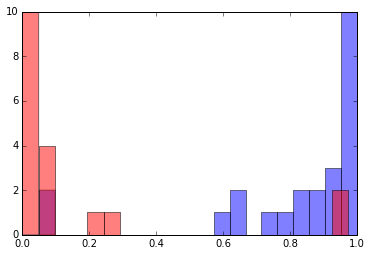

In [31]:
y_proba = folding.predict_proba(X_data)[:, 1]
y_predict = folding.predict(X_data)

from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data, y_proba)

plt.hist(y_proba[y_data==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba[y_data==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,10)
plt.show()

### Tracks Combination

In [32]:
match_tracks = {}
for event_id in reco_events12_new.keys():
    
    ids = data[data.EventID.values == event_id][['track_id_12', 'track_id_34']].values
    probas = y_proba[data.EventID.values == event_id]
    
    match_tracks[event_id] = ids[probas.argsort()[::-1], :][:2, :]
    #match_tracks[event_id] = ids[probas > 0.5, :]
    if len(match_tracks[event_id]) < 2:
        print event_id

In [33]:
charge_dict, pinv_dict, dist_y, dist_x = get_new_matched_tracks(reco_events12_new, reco_events34_new, match_tracks)

true_charge_dict, true_pdg_dict, true_pinv_dict = get_true_match(reco_events12_new, reco_events34_new, match_tracks, all_hits)

# Efficiency

### Stations 1&2

In [34]:
from efficiency import efficiency_per_track

event_id = numpy.array(reco_events12_new.keys())
eff_y, eff_stereo, eff_station = efficiency_per_track(event_id, 
                                            all_hits, 
                                            reco_events12_new)

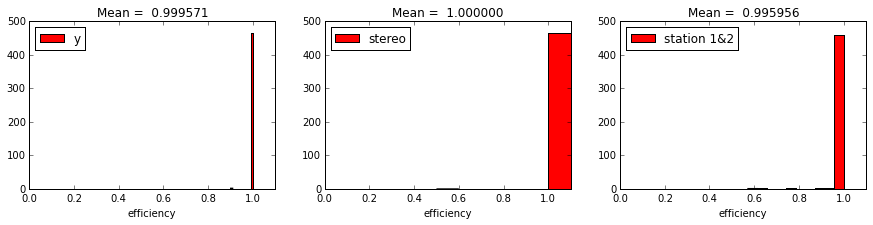

In [35]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.show()

### Stations 3&4

In [36]:
from efficiency import efficiency_per_track

eff_y, eff_stereo, eff_station = efficiency_per_track(reco_events34_new.keys(), 
                                            all_hits, 
                                            reco_events34_new)

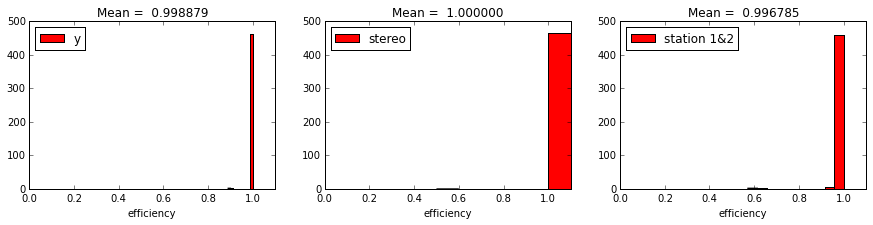

In [37]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.show()

# Efficiency per event

Total efficiency per event is  96.1373390558  %


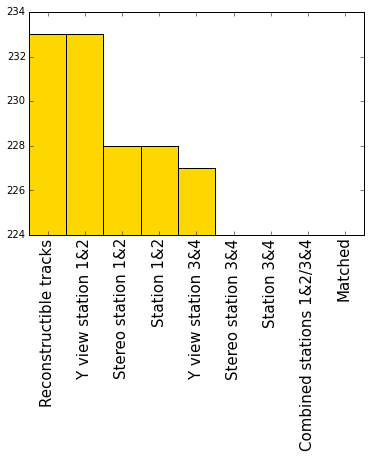

In [38]:
from efficiency import efficiency_per_event, view_check_reco_event

n_events, missed_events = efficiency_per_event(reconstructible_events_new, 
                                               reco_events12_new, 
                                               reco_events34_new, 
                                               match_tracks, 
                                               true_pdg_dict, 
                                               all_hits)

n_events = numpy.array(n_events)

labels = ['Reconstructible tracks', 
          'Y view station 1&2', 
          'Stereo station 1&2', 
          'Station 1&2',
          'Y view station 3&4', 
          'Stereo station 3&4',
          'Station 3&4',
          'Combined stations 1&2/3&4',
          'Matched']

print 'Total efficiency per event is ', 1. * n_events[-1] / n_events[0] * 100., ' %'

x = range(len(labels))
#plt.figure(figsize=(15,5))
plt.bar(x, n_events, width=1., color='gold', align='center')
plt.xticks(x, labels, rotation=90, size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(n_events.min(), n_events.max() + 1)
plt.show()

In [39]:
print n_events
print missed_events

[ 233.  233.  228.  228.  227.  224.  224.  224.  224.]
[1204, 2305, 381, 1793, 102, 1528, 27, 692, 2470]


# Momentum

y = b + kx
k, b =  1.03448975494 8.2672579236e-05
Cov matrix is 
[[  1.50743013e-05  -1.42881211e-07]
 [ -1.42881211e-07   1.47722001e-07]]


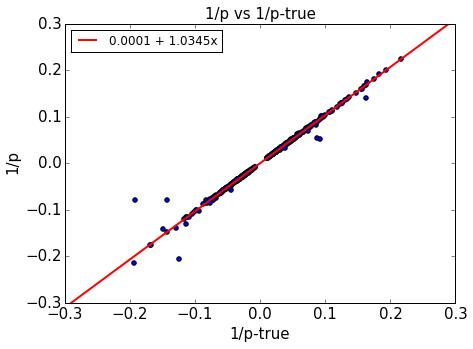

In [40]:
from MatchTracks import get_pinv_true_pinv
        
pinv, true_pinv = get_pinv_true_pinv(pinv_dict, true_pinv_dict, true_charge_dict)
pinv = pinv.reshape(-1)
        

[k, b], cov = numpy.polyfit(true_pinv, pinv, 1, cov=True)
print 'y = b + kx'
print 'k, b = ', k, b
print 'Cov matrix is '
print cov

plt.figure(figsize=(7, 5))
plt.title('1/p vs 1/p-true', size=15)
plt.scatter(true_pinv, pinv)
x = numpy.array([-0.3, 0.3])
plt.plot(x, k * x + b, color='r', linewidth=2, label='%.4f + ' % b + '%.4fx' % k)
plt.legend(loc='best')
plt.ylabel('1/p', size=15)
plt.xlabel('1/p-true', size=15)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

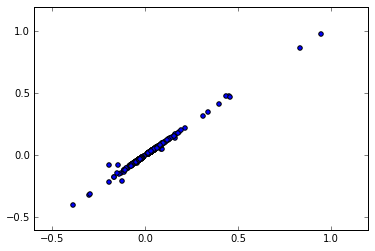

In [41]:
plt.scatter(true_pinv, pinv)
plt.show()

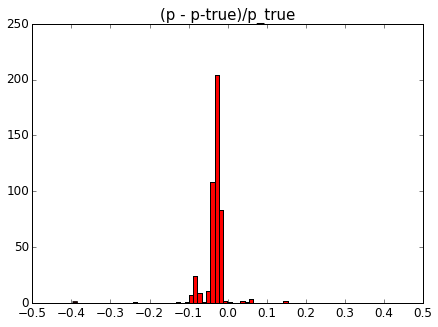

In [42]:
metric = true_pinv/pinv - 1

plt.figure(figsize=(7, 5))
plt.hist(metric[numpy.abs(metric) <= 0.5], bins=50)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()